In [ ]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix} hvplot, dask, contextily

In [ ]:
import ee
import geemap

In [ ]:
Map = geemap.Map(center=(49.939, 8.5), zoom=16)
Map.add_basemap('HYBRID')
Map

#### Define Geometry

In [ ]:
# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature
roi = feature.geometry()

In [ ]:
roi = ee.Geometry({'geodesic': False,
 'type': 'Polygon',
 'coordinates': [[[8.500447, 49.93948],
   [8.501573, 49.939256],
   [8.50116, 49.938403],
   [8.500044, 49.938624],
   [8.500447, 49.93948]]]})
Map.addLayer(roi)
roi = roi.buffer(10000)
Map.addLayer(roi)

#### Filter Sentinel-1 GRD Collection

In [ ]:
s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi) \
    .filterDate('2016-03-01', '2021-10-31') \
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV")) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select(['VV', 'angle']) 

#### Add NDVI Band to S1-GRD Collection

In [ ]:
def add_ndvi(image, dateoffset = 15):
        """
        Arguments: Filter S2 TOA Collection to roi, mask cloudy pixels, calculate NDVI values, Make mosaic from +- 15 days from s1 image
        """
        def maskS2clouds(image):
            qa = image.select('QA60')
            #Bits 10 and 11 are clouds and cirrus, respectively.
            cloudBitMask = 1 << 10
            cirrusBitMask = 1 << 11
            #Both flags should be set to zero, indicating clear conditions.
            mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
            return image.updateMask(mask).divide(10000)

        def NDVI(image):
            ndvi = image.normalizedDifference(['nir','red']).rename('NDVI') #(first − second) / (first + second)
            return image.addBands(ndvi)
        
        # Sentinel 2 image collection with corresponding named bands
        bandNamesOut_s2 = ['Aerosols','blue','green','red','red edge 1','red edge 2','red edge 3','nir','red edge 4','water vapor','cirrus','swir1','swir2','QA60']
        bandNamesS2 = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B10','B11','B12','QA60']
        
        s2_1c = ee.ImageCollection('COPERNICUS/S2').select(bandNamesS2,bandNamesOut_s2)
        s2_1c = s2_1c.filterDate(ee.Date(image.date().advance(-dateoffset,'days')), ee.Date(image.date().advance(+dateoffset,'days'))).filterBounds(image.geometry()).map(maskS2clouds).map(NDVI)
        
        ndvi = ee.Image(s2_1c.qualityMosaic('NDVI').select('NDVI'))

        return image.addBands(ndvi)

In [ ]:
s1_collection = s1_collection.map(add_ndvi)

In [ ]:
#Mask out area with invalid landcover class like build up areas
lc = ee.Image(ee.ImageCollection("ESA/WorldCover/v100").first().clip(roi).select('Map'))
s1_collection = s1_collection.map(lambda x: x.addBands(lc))

#### Split Collection into different observations modes to reduce errors

In [ ]:
desc = s1_collection.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
senA_desc = desc.filter(ee.Filter.eq('platform_number', 'A'))
senB_desc = desc.filter(ee.Filter.eq('platform_number', 'B'))

asc = s1_collection.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
senA_asc = asc.filter(ee.Filter.eq('platform_number', 'A'))
senB_asc = asc.filter(ee.Filter.eq('platform_number', 'B'))

#### Add Soil Water Index

In [ ]:
def add_swi(image):
    swi = image.select('VV').subtract(vvdry_image).divide(vvwet_image.subtract(vvdry_image))
    swi = swi.select('VV').rename('SWI')
    return image.addBands(swi)

In [ ]:
vvdry_image = senA_desc.select('VV').reduce(ee.Reducer.percentile([5]))
vvwet_image = senA_desc.select('VV').reduce(ee.Reducer.percentile([95]))
senA_desc = senA_desc.map(add_swi)

vvdry_image = senB_desc.select('VV').reduce(ee.Reducer.percentile([5]))
vvwet_image = senB_desc.select('VV').reduce(ee.Reducer.percentile([95]))
senB_desc = senB_desc.map(add_swi)

vvdry_image = senA_asc.select('VV').reduce(ee.Reducer.percentile([5]))
vvwet_image = senA_asc.select('VV').reduce(ee.Reducer.percentile([95]))
senA_asc = senA_asc.map(add_swi)

vvdry_image = senB_asc.select('VV').reduce(ee.Reducer.percentile([5]))
vvwet_image = senB_asc.select('VV').reduce(ee.Reducer.percentile([95]))
senB_asc = senB_asc.map(add_swi)

#### Visualizing  time series  data

In [ ]:
vis_params_VV = {
  'min': -30,
  'max': 0,
  'palette': ['red', 'blue']
}
vis_params_NDVI = {
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']
}
vis_params_SWI = {
  'min': 0,
  'max': 1,
  'palette': ['red','orange','lightblue', 'blue']
}

In [ ]:
Map = geemap.Map(center=(49.75, 8.5), zoom=10)
Map.add_basemap('HYBRID')
image = senA_desc.select('NDVI').toBands()
Map.addLayer(image, {}, "Time series NDVI - s2 toa", False)
labels = [str(n).zfill(2) for n in range(senA_desc.size().getInfo())]
Map.add_time_slider(senA_desc.select('NDVI'), vis_params_NDVI, labels=labels, time_interval=1)
Map

## Download an ee.ImageCollection

In [ ]:
#clip collection to roi extend and export images
geemap.ee_export_image_collection(senA_desc, out_dir='C://Users/USER/Downloads/gee_downloads/senA_desc', region=roi, file_per_band=True, scale=50)

In [ ]:
geemap.ee_export_image_collection(senB_desc.select(['VV','Map', 'NDVI']) , out_dir='C://Users/USER/Downloads/gee_downloads/senB_desc', region=roi, file_per_band=True, scale=50)

In [ ]:
geemap.ee_export_image_collection(senA_asc.select(['VV','Map', 'NDVI']), out_dir='C://Users/USER/Downloads/gee_downloads/senA_asc', region=roi, file_per_band=True, scale=50)

In [ ]:
geemap.ee_export_image_collection(senB_asc.select(['VV','Map', 'NDVI']), out_dir='C://Users/USER/Downloads/gee_downloads/senB_asc', region=roi, file_per_band=True, scale=50)

#### Open files in xarray

In [2]:
import glob
import xarray as xr
import rioxarray as rio

In [66]:
files = glob.glob('C://Users/USER/Downloads/gee_downloads/senA_desc/*.tif')

In [ ]:
from datetime import datetime

In [67]:
def preprocess_s1(da):
    from datetime import datetime
    da = da.drop('spatial_ref').sel(band=1).drop('band')
    #da['y'] = da['y'].round(4)
    #da['x'] = da['x'].round(4)
    filename = da.encoding["source"]
    variable = filename.split('.')[-2]
    date = datetime.strptime(filename.split('_')[6], '%Y%m%dT%H%M%S')
    da['time'] = date
    da = da.set_coords('time').expand_dims('time')
    da = da.isel(x=slice(0,404), y=slice(0,403))
    if variable == 'angle':
        da = da.rename({'band_data' : 'angle'})
    elif variable == 'NDVI':
        da = da.rename({'band_data' : 'NDVI'})
    elif variable == 'SWI':
        da = da.rename({'band_data' : 'SWI'})
    elif variable == 'Map':
        da = da.rename({'band_data' : 'landcover'})
    else:
        da = da.rename({'band_data' : 'VV'})
    return da
                                      
data = xr.open_mfdataset(files, engine='rasterio', preprocess=preprocess_s1, )#

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\xarray\core\indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(

In [68]:
data

C:\Users\USER\Anaconda3\envs\gee\lib\site-packages\dask\array\core.py:1479: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:  (x: 136734, y: 136433, time: 338)
Coordinates:
  * x        (x) float64 -2.487e+06 -2.487e+06 ... 4.743e+05 4.743e+05
  * y        (y) float64 5.522e+06 5.522e+06 5.522e+06 ... 6.465e+06 6.465e+06
  * time     (time) datetime64[ns] 2016-03-02T05:42:02 ... 2021-10-26T05:42:46
Data variables:
    NDVI     (time, y, x) float32 dask.array<chunksize=(1, 136433, 136734), meta=np.ndarray>

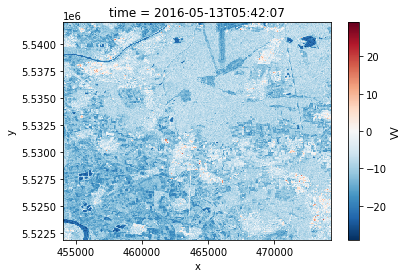

In [57]:
data.isel(time=12).VV.plot()

In [11]:
master_coordinate = xr.open_rasterio(files[-1])

C:\Users\USER\AppData\Local\Temp/ipykernel_5904/2034717900.py:1: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  xr.open_rasterio(files[1])


<xarray.DataArray (band: 1, y: 403, x: 404)>
[162812 values with dtype=uint8]
Coordinates:
  * band     (band) int32 1
  * y        (y) float64 5.542e+06 5.542e+06 5.542e+06 ... 5.522e+06 5.522e+06
  * x        (x) float64 4.541e+05 4.541e+05 4.542e+05 ... 4.742e+05 4.742e+05
Attributes:
    transform:               (50.0, 0.0, 454073.59452407924, 0.0, -50.0, 5542...
    crs:                     +init=epsg:32632
    res:                     (50.0, 50.0)
    is_tiled:                1
    nodatavals:              (0.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [ ]:
monthly_mean = data.resample(time='1m').mean()
#yearly_mean = data.groupby('time.year').groupby('year.month').mean()

In [ ]:
df = yearly_mean.to_dataframe().reset_index()
df[['x','y']] = df[['x','y']].round(4)

In [ ]:
ymean = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x,df.y))

In [ ]:
monthly_mean.NDVI.plot.contourf(x='x', y='y', col='month')

In [ ]:
monthly_mean.NDVI.plot(x='x', y='y', col='month', levels=[0.1,0.2,0.3,0.4,0.5,0.6,1])

In [ ]:
monthly_mean.NDVI.plot.contour(x='x', y='y', col='month', levels=[0.1,0.2,0.3,0.4,0.5,0.6,1])

In [ ]:
monthly_mean.NDVI.plot.contour(x='x', y='y', col='month', levels=7)

In [ ]:
monthly_mean.NDVI.plot.contour(x='x', y='y', col='month', levels=[0.1,0.2,3,0.5,0.6,1])

In [ ]:
import hvplot.xarray  # noqa

In [ ]:
monthly_mean


In [ ]:
monthly_mean['NDVI'].plot.contour(col='time', robust=True, col_wrap=12, cmap='CMRmap', levels=6)

In [ ]:
monthly_mean.NDVI.hvplot(col='month')

In [ ]:
ndvi = monthly_mean.hvplot(x='x', y='y', col='month',width=192, height=132, yaxis=False, xaxis=False, colorbar=False, cmap='viridis')
ndvi

## Extract pixels as a Numpy array

In [ ]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

rgb_img = geemap.ee_to_numpy(img, region=aoi)
print(rgb_img.shape)

In [ ]:
# Scale the data to [0, 255] to show as an RGB image. 
# Adapted from https://bit.ly/2XlmQY8. Credits to Justin Braaten
rgb_img_test = (255*((rgb_img[:, :, 0:3] - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

# Export Mean Data from Gee as array

In [ ]:
import geemap
import ee
from irrigation_detection import add_ndvi
from irrigation_detection import mask_by_landcover

In [ ]:
Map = geemap.Map(center=(49.939, 8.5), zoom=16)
Map.add_basemap('HYBRID')
Map

In [ ]:
# Draw any shapes on the map using the Drawing tools before executing this code block
feature = Map.draw_last_feature
roi = feature.geometry()
aoi = roi.buffer(10000)
Map.addLayer(aoi)

In [ ]:
s1_collection = ee.ImageCollection("COPERNICUS/S1_GRD") \
    .filterBounds(roi) \
    .filterDate('2016-03-01', '2021-10-31') \
    .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV")) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select(['VV', 'angle']) 

#Add ndvi band with 15 day offsett for s2 images
s1_collection = s1_collection.map(add_ndvi)

In [ ]:
#Mask out area with invalid landcover class like build up areas
lc = ee.Image(ee.ImageCollection("ESA/WorldCover/v100").first().clip(aoi).select('Map'))
s1_collection = s1_collection.map(lambda x: x.addBands(lc))
s1_collection = s1_collection.map(mask_by_landcover)

In [ ]:
Map.addLayer(s1_collection.first(), {'min': -30, 'max': 0, 'palette': ['red', 'blue']})